3 single member complexes removed
recalculating on largest connected component.
There are 113 component(s).
The top largest component sizes are Any[1739, 22, 17, 13, 13, 13, 12, 11, 11, 10].
There is 0 singleton component(s).
New hypergraph has 558 weighted edges.
Hypergraph has 
558 edges containing 558 set(s).
Nodes essential: 693 Edges essential: 230
Creating mappings for function set A_B_summary 
________________________________________________
5%: 34 proteins
max number of TP proteins: 31 for 2 set(s): Any["P:(0,1,0,1)", "P:(1/95,95,1,1/95)"]
---------------------------------------------------------
10%: 69 proteins
max number of TP proteins: 56 for 1 set(s): Any["P:(1,1,46,29/46)"]
---------------------------------------------------------
25%: 173 proteins
max number of TP proteins: 136 for 1 set(s): Any["P:(1,1,46,29/46)"]
---------------------------------------------------------
50%: 346 proteins
max number of TP proteins: 178 for 1 set(s): Any["P:(1,1,46,29/46)"]
-------------

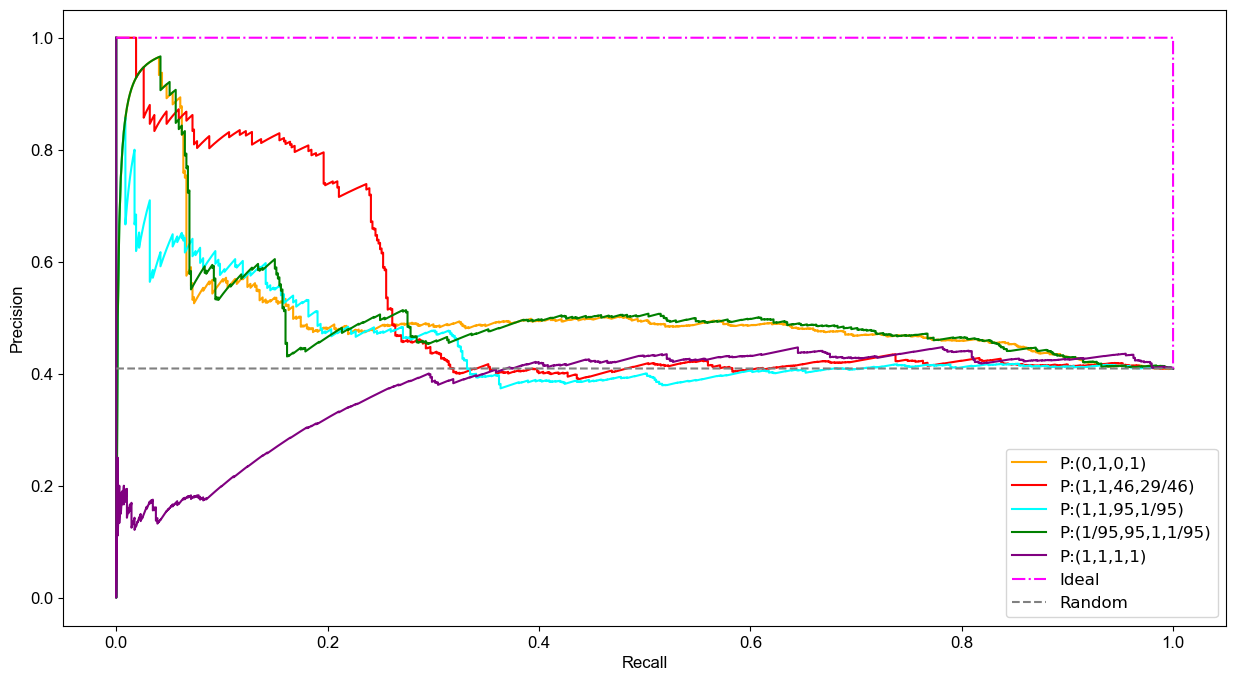

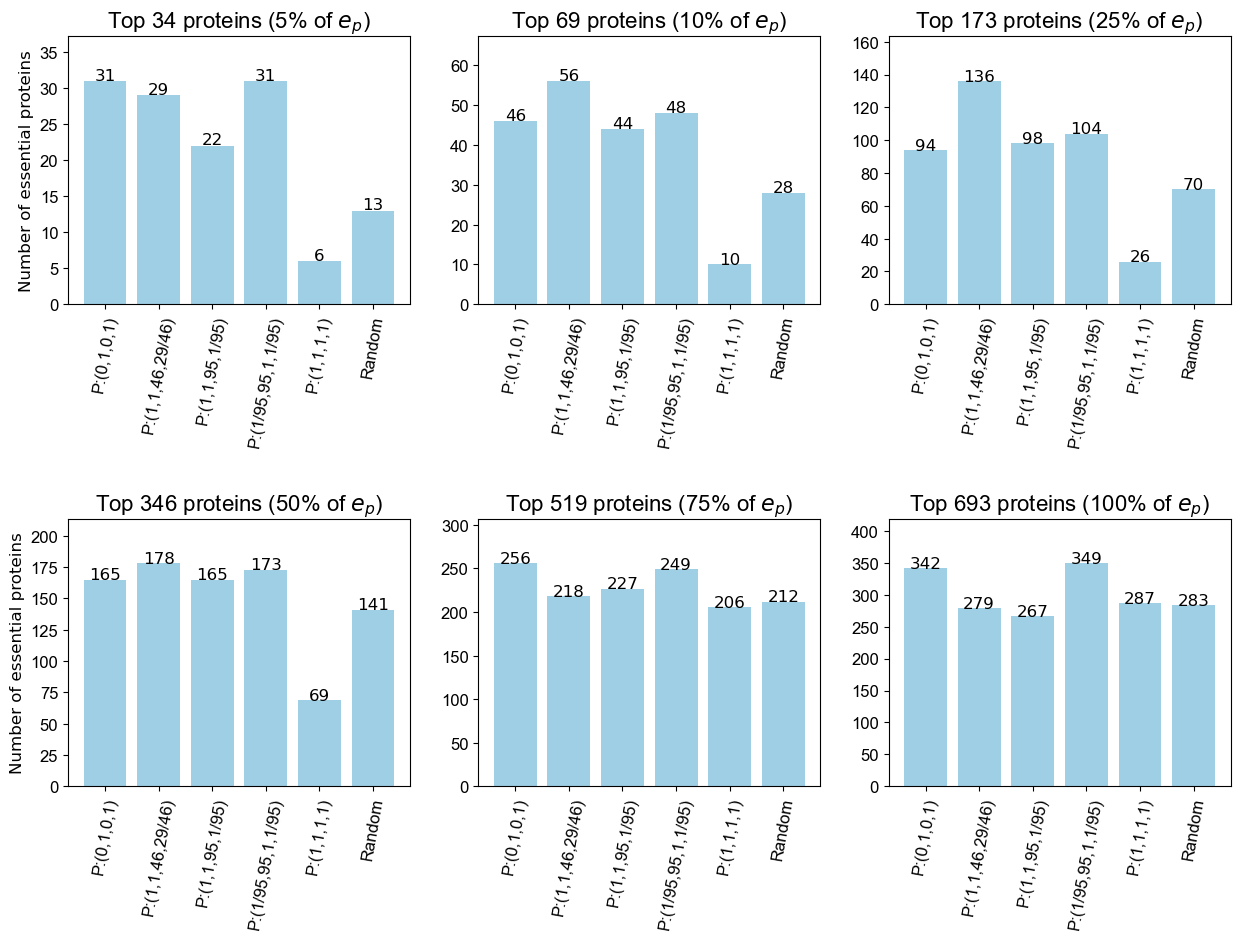

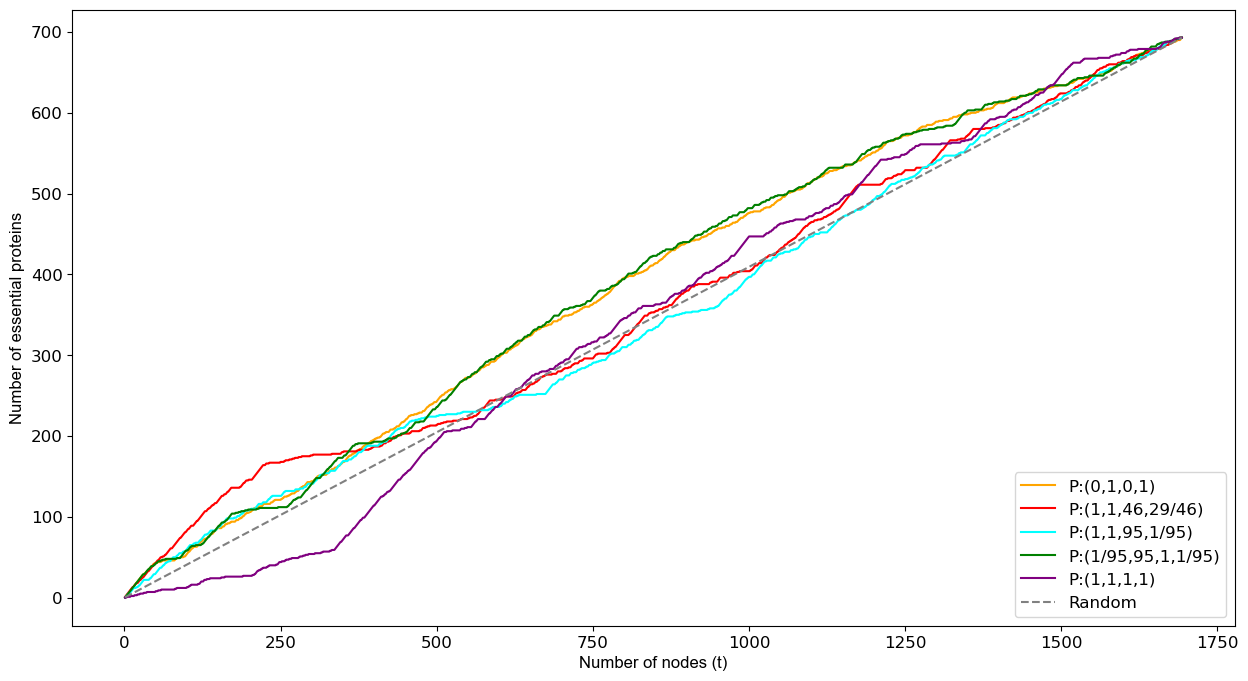

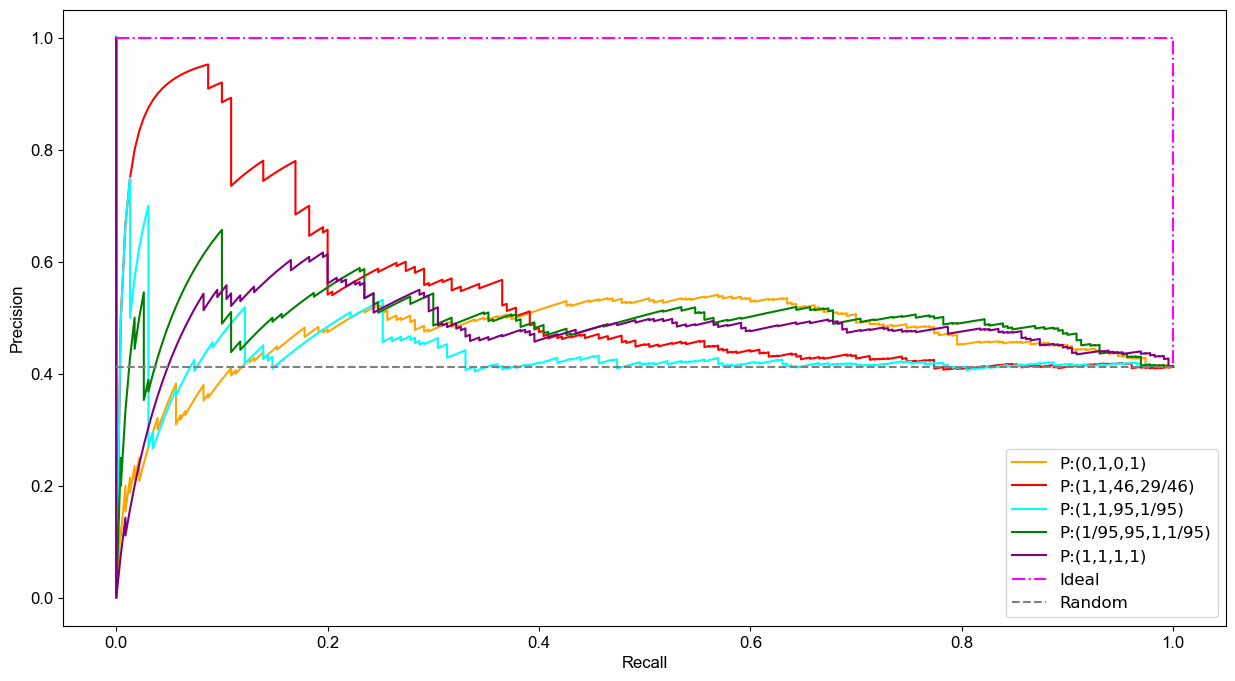

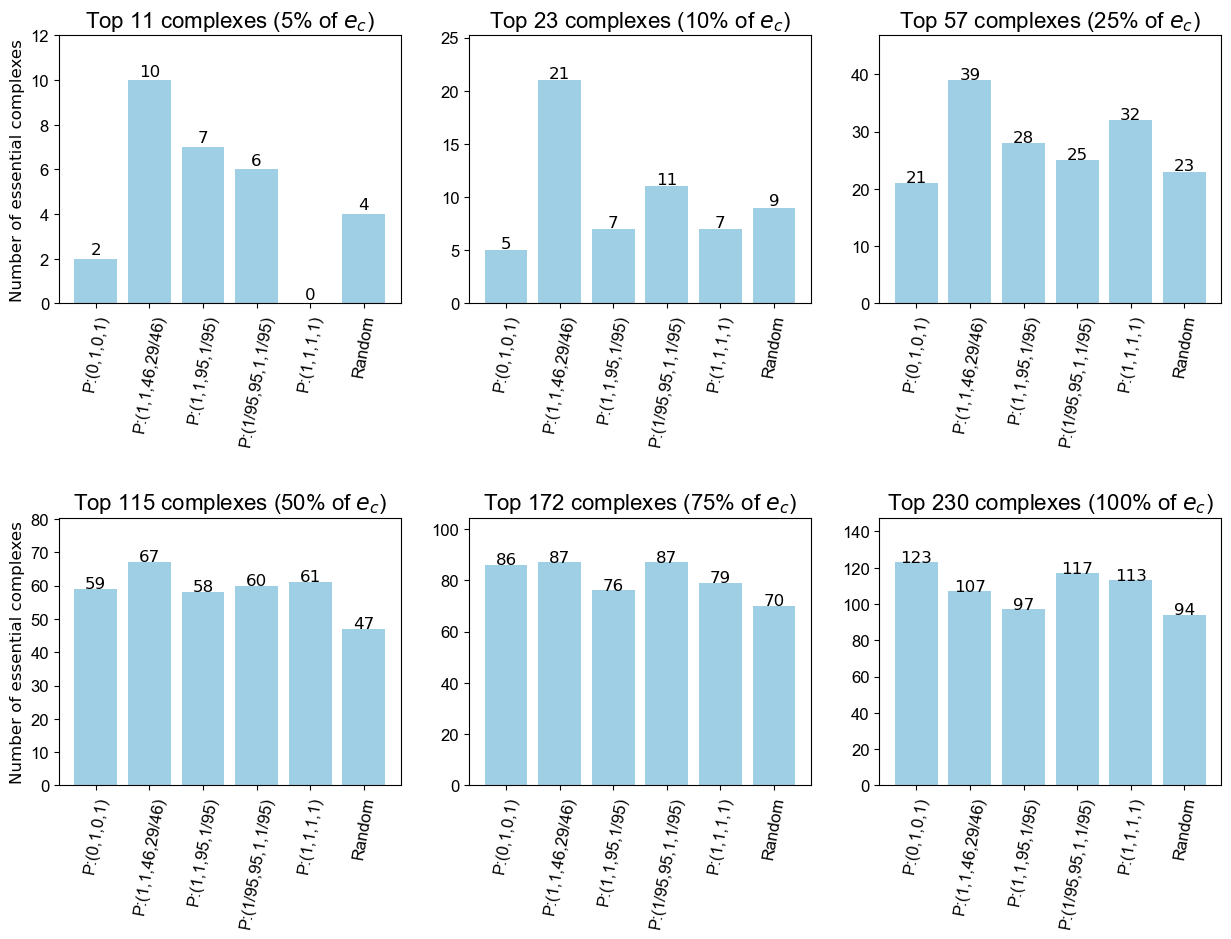

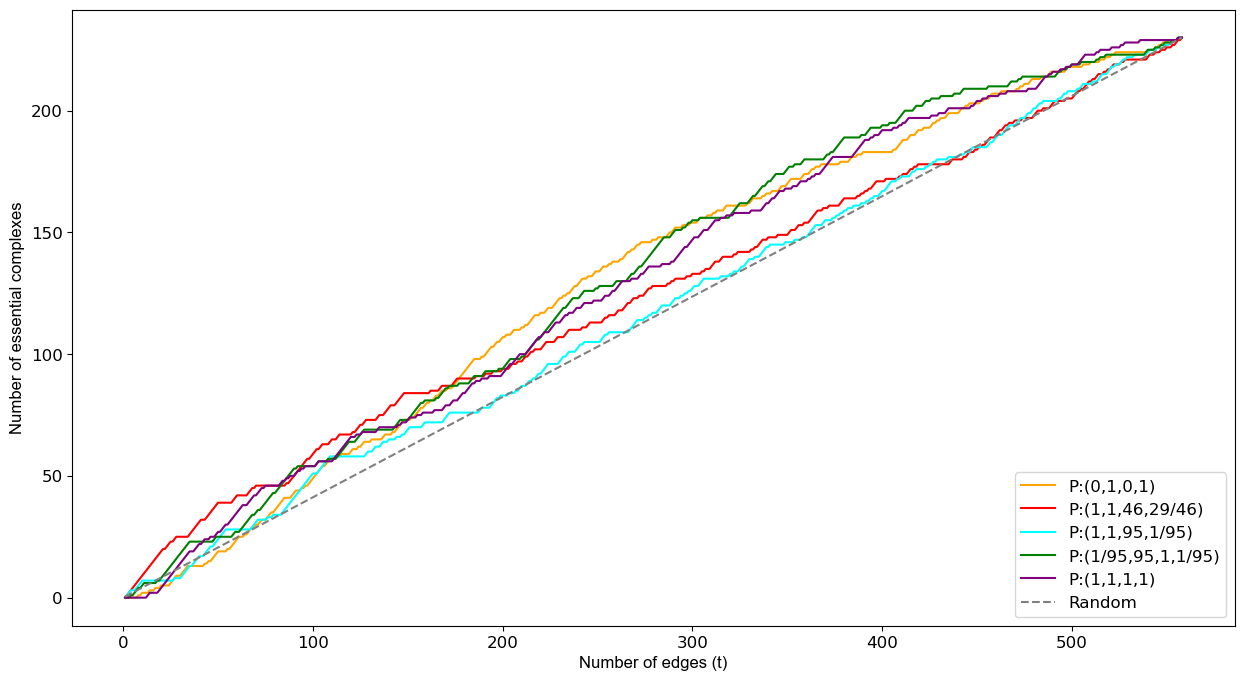

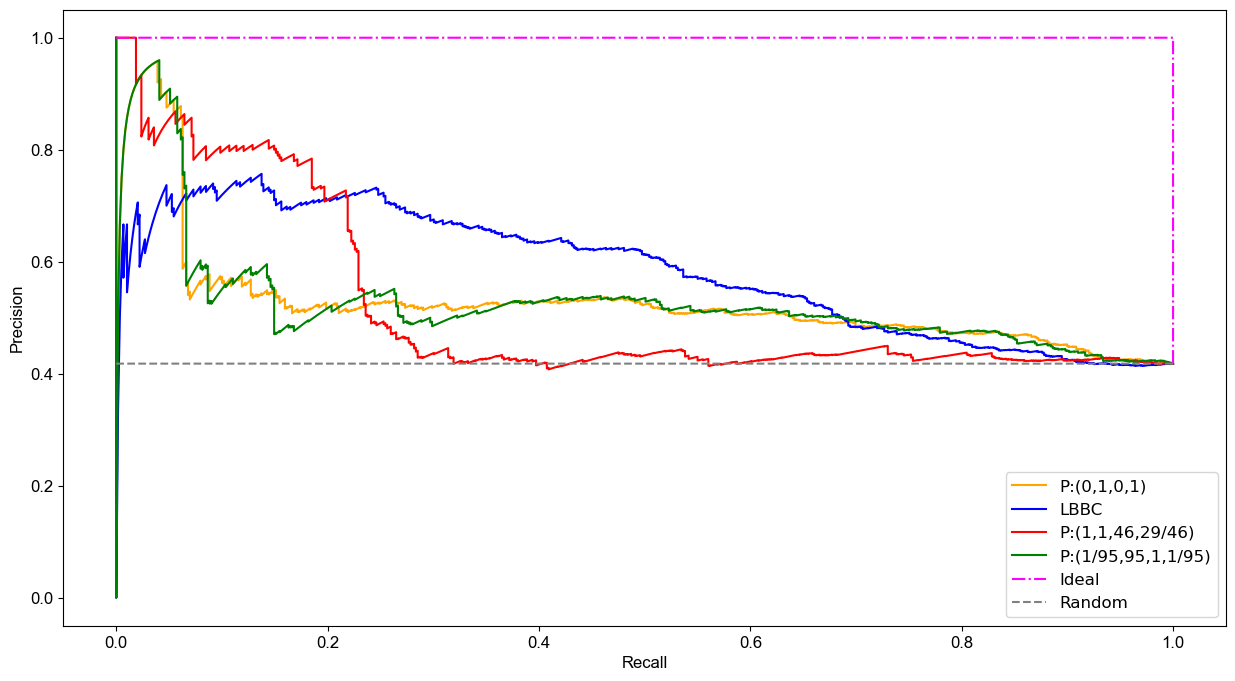

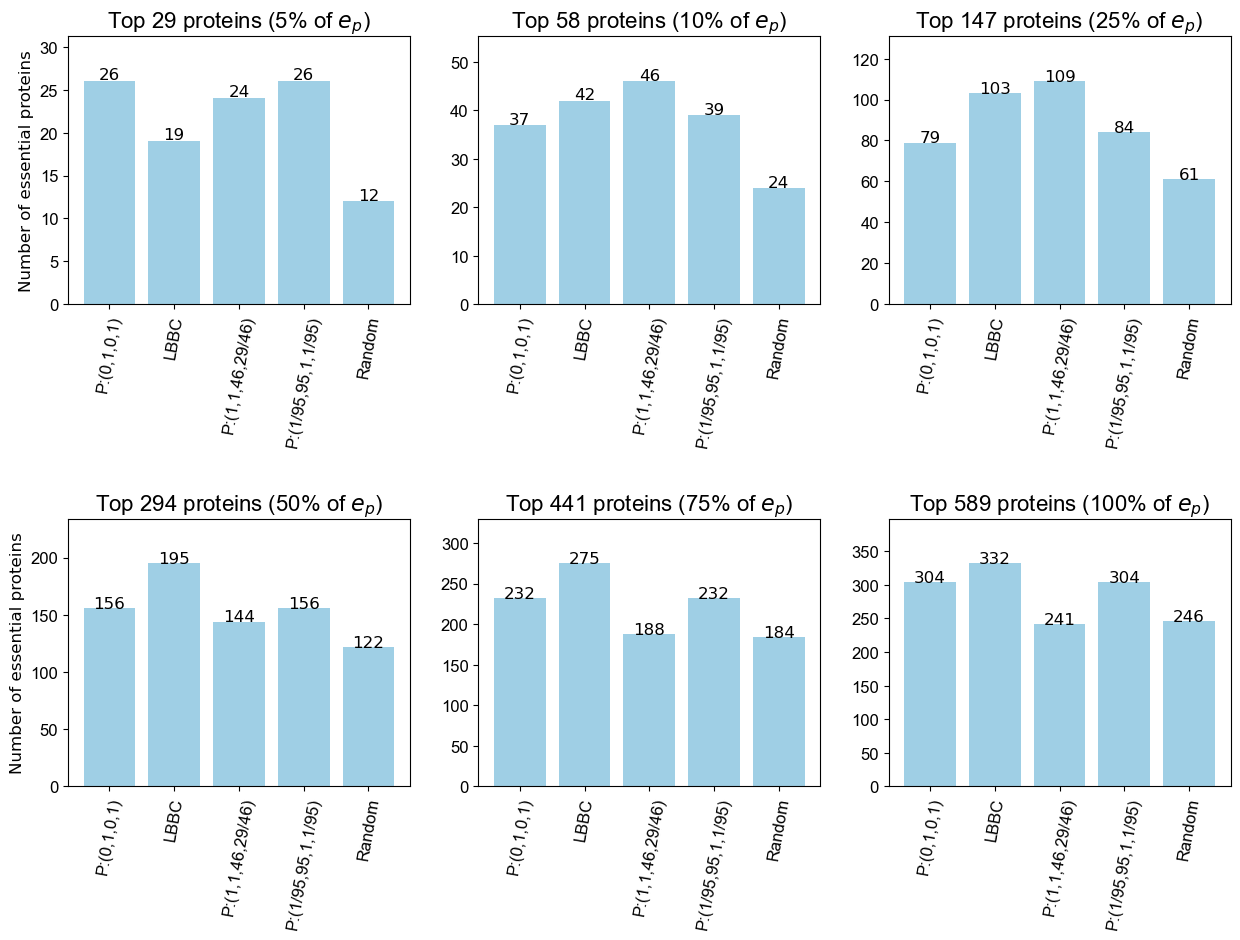

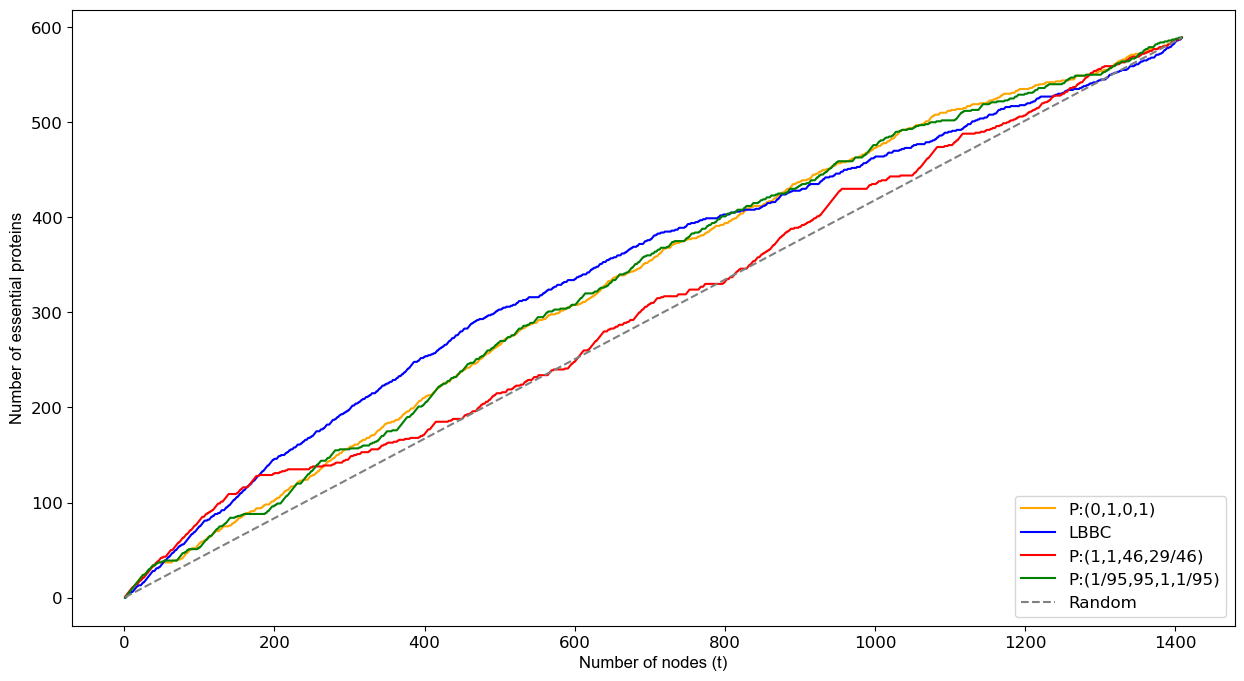

In [23]:
#DELETE OUTPUTS AND RESTART KERNAL BEFORE RUNNING
#RUN THIS FILE TO REPRODUCE RESULTS FROM 
#"An application of node and edge nonlinear hypergrpah centrality to a protein complex hypernetwork." Lawson, S., Donovan, D., Lefevre,J. School of Mathematics and Physics, University of Queensland 2024 (unpublished). 
using JLD2 
using SparseArrays
using StatsBase
using PyPlot
using Plots
using SimpleHypergraphs
using Trapz
using Graphs
using LinearAlgebra
using EvalMetrics
using Combinatorics
using DelimitedFiles

file_path = "C:\\Users\\sarit\\RA_code\\NSVC_git_repo\\PCH_node_edge_centrality" #file path for code folder
output_path = "$file_path\\Outputs" #output folder for text files and plots
include("$file_path\\data_processing_functions.jl")
include("$file_path\\mappings_initialization.jl") 
include("$file_path\\compute_centrality_functions.jl")
include("$file_path\\analysis_functions.jl") 
include("$file_path\\helper_functions.jl") 
include("$file_path\\plot_functions.jl") 
include("$file_path\\high_performance.jl") 
lbbc_cent_file="$file_path\\yeast_raw_data\\LBBC_centralities.txt"

#CHOOSE FUNCTION SETS - COMMENT OUT ALL FUNCTION SETS OTHER THAN ONE NEEDED  
varying = 
#"setA"
#"setB_summary"
"A_B_summary" #Also used for LBBC comparison 
                       

# "1_1_c_k/c"   #Full set of c, d=k/c for c,k in range 0.1:95  presaved as setA_1_1_c_kc_centralities-load below
# "setB_complete" #   #Full set B centralitites for a,b,c,d presaved as setB_comb_0_1_195_95_centralities-load below

#Algorithm parameters
max_iterations = 800
tolerance = 1e-6

#percentage of essential proteins as edge essentiality criteria:

e_percentage = 0.6  #at least 60% essential proteins in complex


#6 percentage thresholds 
percent_threshold = [0.05, 0.10, 0.25, 0.50, 0.75, 1.0];


#Process yeast complexes and essentiality data:
dataset_name = "yeast_protein"
name_title = "Yeast Protein Complexes"
file = "$file_path\\yeast_raw_data\\raw_complex_yeast.txt"
essential = "$file_path\\yeast_raw_data\\essential_proteins_yeast.txt"
nonessential = "$file_path\\yeast_raw_data\\nonessential_proteins_yeast.txt"
set_dict = yeast_complexes_set_dict(file) #create dictionary of complexes from raw file

#Remove single member sets from set_dict:
s = 0
for i in keys(set_dict)
    if length(set_dict[i]) == 1
        delete!(set_dict, i)
        s += 1
    end
end
println(s, " single member complexes removed")

#create text files to outputs folder and a dict with key:node name and value: node number. 
node_numbers_dict = data_processing(set_dict, dataset_name, output_path)


##############################################################################################################
#CREATE HYPERGRAPH
B, w, edgesx, edges_fromB, node_names_list, connected = read_hypergraph_data(
    dataset_name,
    output_path,
    max_iterations = max_iterations,
    tolerance = tolerance,
);

if !connected
    #recaluclate for largest connected component:
    #save original data:
    orig_w = w
    orig_B = B
    orig_edges_fromB = edges_fromB
    orig_set_dict = set_dict
    orig_node_numbers_dict = node_numbers_dict
    orig_node_names_list = node_names_list
    orig_edges = edgesx
    println("recalculating on largest connected component.")
    B, w, edgesx, edges_fromB, node_names_list, set_dict, dataset_name, node_numbers_dict =
        max_component_recalculate(B, node_numbers_dict, set_dict, dataset_name)

end

#count nodes, edges and original sets
no_nodes = size(B)[1]
no_edges = size(B)[2]
no_sets = Int(sum(w))

println(
    "Hypergraph has 
$no_edges edges containing $no_sets set(s).",
)

#dictionary containing key:node, value:list of edges node belongs to 
node_edges_dict = node_in_edges(node_numbers_dict, edges_fromB)

#dictionary containing key:edge number value:original sets represented
edge_number_dict = edge_numbers_dict(node_numbers_dict)

#create dictionary of node and edge degrees
ia = false #if ia = false then does not include max_edge, node adjacency, mean_deg in degree_centralities
deg_centralities, edge_deg_centralities =
    deg_centralities_dict(B, node_edges_dict, edges_fromB, edge_weights = w, inc_adj = ia)

#create dictionary of nodes and edge essentiality status and print number of essential/nonessential nodes/edges
node_ess_dict, unk, n_essent, n_non_essent =
    node_class_dict(node_names_list, essential, nonessential, printlines = false)

edge_ess_dict, e_essent, e_non_essent = edge_class_dict(
    node_ess_dict,
    edges_fromB,
    node_names_list,
    printlines = false,
    per_ess = e_percentage,
);

println("Nodes essential: ", n_essent, " Edges essential: ", e_essent)

#################################################################################################################
#Create or load centrality dictionary. 

#Comment out following if uploading saved dictionaries
centralities, ranked_nodes_dict, ranked_edges_dict, mappings =
    initialization(varying); #centralitites based on 'varying' parameter

#large centrality dictionaries have been saved and can be preloaded:
#centralities=load_object("setA_1_1_c_kc_centralities.jld2") #centralitites for functions of the form P:(1,1,c,k/c) for c,k in range 0.1:95
#centralities=load_object("setB_comb_0_1_195_95_centralities.jld2") #centralitites for functions of the form P:(a,b,c,d) with a,c in {0,1,95,1/95} and b,d in {1,95,1/95}}

#print summary of maximum true positives for centralities
println("________________________________________________")
for cent_type in ["x", "y"]
    for i in percent_threshold
        max_true_pos(
            cent_type,
            centralities,
            i,
            n_essent,
            e_essent,
            n_non_essent,
            e_non_essent,
            node_ess_dict,
            edge_ess_dict;
            printlines = false,
            reverse = true,
        )
    end

    println("________________________________________________")

end


#comment out the following if centrality dictionary is large e.g. usio\ng large uploaded dictionaries
# print summary of AUC and create plots

for cent_type in ["x", "y"]
    measures_dict = all_class_measures_plots(
        cent_type,
        centralities,
        deg_centralities,
        edge_deg_centralities,
        n_essent,
        n_non_essent,
        node_ess_dict,
        e_essent,
        e_non_essent,
        edge_ess_dict,
        percent_threshold,
        printlines = false,
        varying = varying
    )
end

##print out max auc for node and edge high performers for setA_1_1_c_kc_centralities.jld2 and setB_comb_0_1_195_95_centralities.jld2

#high_peform(n_essent, n_non_essent, e_essent, e_non_essent, node_ess_dict,edge_ess_dict)

#######################################################################################################

#analyse intersection of MIPS-PIN and PCH

println("\n----------------PIN_PCH INTERSECTION ANALYSIS-----------------------")
#create cent_dictionary from LBBC-MIPS text file:
lbbc_dict=read_LBBC_cent(lbbc_cent_file)
lbbc_all_names=collect(keys(lbbc_dict))

#create essentiality status dictionary for all nodes in MIPS-PIN
lbbc_node_ess_dict,u,e,ne=node_class_dict(lbbc_all_names, essential, nonessential; printlines=true)


#list of centralities corresponding to name at same index in lbbc_all_names
lbbc_all_cent=[]
for key in lbbc_all_names
    push!(lbbc_all_cent,lbbc_dict[key])
end

#list of essentiality corresponding to name at same index in lbbc_all_names
lbbc_all_status=[]
for name in lbbc_all_names
        push!(lbbc_all_status,lbbc_node_ess_dict[name] )
end

#create vectors for ranked by name, essentiality and centrality 
index = sortperm(vec(lbbc_all_cent),rev=true) #indexes for order of centralities
lbbc_ranked_cent=lbbc_all_cent[index] #rank by cent
lbbc_ranked_names=lbbc_all_names[index] #rank by name
lbbc_ranked_status=lbbc_all_status[index] #rank by essentiality

#rank essentiality by binary
lbbc_ranked_binary=[] #excluding unknowns
for i in lbbc_ranked_status
    if i=="essential"  
        push!(lbbc_ranked_binary,1)
    elseif i=="nonessential"
        push!(lbbc_ranked_binary,0)
    end
end

#Restrict to intersection

#list of proteins in intersection by name
int_prots= readlines("$file_path\\yeast_raw_data\\PIN_PCH_intersection.txt")

#create LBBC dictionary key:node_number to value:centrality (matching to proteins node nunmber in PCH):
lbbc_cent=Dict()
for key in keys(lbbc_dict) #for each protein in MIPS
    if key in keys(node_numbers_dict) #if protein in NSVC PCH
        lbbc_cent[node_numbers_dict[key]]=lbbc_dict[key] #add key:protein node number value:lbbc centrality
    end
end

#sorted array of node numbers for list of intersecting proteins
sorted_int_nodes=sort([node_numbers_dict[i] for i in int_prots])

#list of lbbc centralities ordered by node number
lbbc_cents=[lbbc_cent[i] for i in sorted_int_nodes]

#create intersection centralities dictionary and add LBBC centralities
int_centralities=Dict("LBBC" => Dict("x" => lbbc_cents, "y"=> [0]))

function_sets=["P:(0,1,0,1)", "P:(1/95,95,1,1/95)","P:(1,1,46,29/46)"]
#ensure these centralities have been calculated in current centralities dictionary (ie for the chosen 'varying' parameter)

#reduce centrality values for specified function sets in active NSVC centralities dict to nodes in intersection and add to intersect dictionary
for key in keys(centralities)
    if key in function_sets
        red_cents_1=[centralities[key]["x"][i] for i in sorted_int_nodes]
        int_centralities[key]= Dict("x" => red_cents_1, "y"=> [0])
    end
end 

#node_ess_dict for intersect nodes:
int_node_ess_dict=Dict()
for i in int_prots
        int_node_ess_dict[i]=node_ess_dict[i]
end

#list of essential and non-essential nodes
int_ness_nodes=[name for name in int_prots if node_ess_dict[name]=="nonessential" ] 
int_ess_nodes=[name for name in int_prots if node_ess_dict[name]=="essential" ] 
int_n_essent=length(int_ess_nodes)
int_n_non_essent=length(int_ness_nodes)

println("number of nodes in intersection: ", length(int_prots))
println("essential nodes in intersection: ", int_n_essent )
println("nonessential nodes in intersection: ", int_n_non_essent)


#perform analysis
cent_type="x"
measures_dict = all_class_measures_plots(
    cent_type,
    int_centralities,
    deg_centralities,
    edge_deg_centralities,
    int_n_essent,
    int_n_non_essent,
    int_node_ess_dict,
    e_essent,
    e_non_essent,
    edge_ess_dict,
    percent_threshold,
    printlines = false,
    varying = varying,
    pin_pch_int=true, 
    int_node_numbers=sorted_int_nodes
)

println("PLOTS \n
    PCH node: 1)Prec-rec 2)Box 3)Cumulative; \n
    PCH edge: 4)Prec-rec 5)Box 6)Cumulative; \n
    PIN-PCH Intersection: node 7)Prec-rec, 8)Box 9)Cumulative ")


In [ ]:
# #average rank for ess proteins for NSVC centralities
# println("\nPCH-NSVC average ranking of essential proteins")
# for cent in keys(centralities)
#     rank_by_number, rank_by_name, rank_by_name_exc, rank_by_centralities,rank_by_binary,rank_by_class=
# rank_arrays(centralities[cent]["x"], "x", node_ess_dict; reverse=true, pin_pch_int=false, int_node_numbers=[])
#     ess_idx=[]
#     for name in rank_by_name
#         if node_ess_dict[name]=="essential"
#             push!(ess_idx,findall(x->x==name, rank_by_name)[1])
#         end
#     end
#       println(" $cent", mean(ess_idx), " Sd: ", std(ess_idx))      
        
#     int_ess_idx=[]
#     for name in int_ess_nodes
#         push!(int_ess_idx,findall(x->x==name, rank_by_name)[1])
#     end
#     println("Restricted $cent", mean(int_ess_idx)," Sd: ", std(int_ess_idx))
# end

# lbbc_tops=e+ne


# cent_type="x"
# measures_dict = all_class_measures_plots(
#     cent_type,
#     centralities,
#     deg_centralities,
#     edge_deg_centralities,
#     n_essent,
#     n_non_essent,
#     node_ess_dict,
#     e_essent,
#     e_non_essent,
#     edge_ess_dict,
#     percent_threshold,
#     printlines = false,
#     varying = varying,
#     percentage=true,
#     lbbc=true,
    
    
#     pin_pch_int=false, 
#     lbbc_tops=lbbc_tops,
#     lbbc_ranked_binary=lbbc_ranked_binary,
#     lbbc_node_ess_dict=lbbc_node_ess_dict
# )


